In [1]:
#https://pytorch.org/tutorials/beginner/nn_tutorial.html

import matplotlib.pyplot as plt
import sys,os,re,glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import seaborn as sns
# sori -module
sys.path.append('/home/ysorimachi/tool')
from getErrorValues import me,rmse,mae,r2 #(x,y)
from convSokuhouData import conv_sfc #(df, ave=minutes,hour)

#---------------------------------------------------
import subprocess
import requests
#--------------------------
import pickle
import gzip
from pathlib import Path
import torch

In [4]:
torch.__version__
# subprocess.run("conda info -e", shell=True)
!conda info -e

# conda environments:
#
py2                      /home/ysorimachi/.conda/envs/py2
sori_conda               /home/ysorimachi/.conda/envs/sori_conda
sori_earthquake          /home/ysorimachi/.conda/envs/sori_earthquake
sori_geo                 /home/ysorimachi/.conda/envs/sori_geo
sori_torch            *  /home/ysorimachi/.conda/envs/sori_torch
base                     /opt/pyenv/versions/miniconda3-latest
anaconda201910           /opt/pyenv/versions/miniconda3-latest/envs/anaconda201910
elf208                   /opt/pyenv/versions/miniconda3-latest/envs/elf208



In [5]:
DATA_PATH = "/home/ysorimachi/work/sori_py2/deepl/dat/data"
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [8]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [9]:
x_train.shape

(50000, 784)

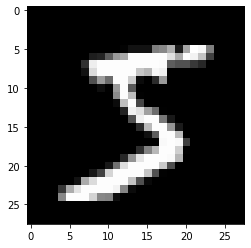

In [10]:
plt.imshow(x_train[0].reshape((28,28)),cmap="gray")

In [18]:
x_train,y_train, x_valid,y_valid = map(torch.tensor, (x_train, y_train,x_valid, y_valid))
n,c = x_train.shape

print(x_train.shape)
print(y_train.min(), y_train.max())

torch.Size([50000, 784])
tensor(0) tensor(9)


In [19]:
weights = torch.randn(784,10)/ math.sqrt(784)
print(weights)
weights.requires_grad_()
print(weights)
bias = torch.zeros(10, requires_grad = True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)


tensor([[ 0.0070,  0.0561,  0.0422,  ..., -0.0365,  0.0234, -0.0236],
        [ 0.0418,  0.0033,  0.0292,  ..., -0.0108,  0.0118,  0.0005],
        [-0.0115, -0.0118,  0.0185,  ...,  0.0037,  0.0164, -0.0034],
        ...,
        [ 0.0633, -0.0030,  0.0557,  ...,  0.0403,  0.0142,  0.0091],
        [-0.0256,  0.0058,  0.0122,  ...,  0.0322, -0.0411,  0.0316],
        [ 0.0049,  0.0162,  0.0112,  ...,  0.0443,  0.0822,  0.0409]])
tensor([[ 0.0070,  0.0561,  0.0422,  ..., -0.0365,  0.0234, -0.0236],
        [ 0.0418,  0.0033,  0.0292,  ..., -0.0108,  0.0118,  0.0005],
        [-0.0115, -0.0118,  0.0185,  ...,  0.0037,  0.0164, -0.0034],
        ...,
        [ 0.0633, -0.0030,  0.0557,  ...,  0.0403,  0.0142,  0.0091],
        [-0.0256,  0.0058,  0.0122,  ...,  0.0322, -0.0411,  0.0316],
        [ 0.0049,  0.0162,  0.0112,  ...,  0.0443,  0.0822,  0.0409]],
       requires_grad=True)


In [21]:
batch_size = 64
x_batch = x_train[0:batch_size]
preds = model(x_batch)

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [22]:
y_batch = y_train[0:batch_size]
loss_func(preds, y_batch)

tensor(2.2503, grad_fn=<NegBackward>)

In [23]:
def accuracy(out,targets):
    preds = torch.argmax(out,dim=1)
    return (preds==targets).float().mean()
accuracy(preds, y_batch)    

tensor(0.1250)

In [24]:
# training loop program
from IPython.core.debugger import set_trace

lr = 0.5
epochs =2

for epoch in range(epochs):
    for i in range((n-1)// batch_size + 1):
        # set_trace()
        
        start_i = i* batch_size
        end_i = start_i + batch_size
        
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        #この処理で、weights.gradsと、bias.grads　に微分した結果が格納される
        loss.backward() #backpropagation 
        
        with torch.no_grad():
            # weights.gradsには、weightの数値微分した結果がtensorで格納されているので、broadcastでlrを掛けた値を引き算して更新する 
            weights -= weights.grad * lr 
            bias -= bias.grad * lr
            #次の為に、勾配を初期化しておく
            weights.grad.zero_()
            bias.grad.zero_()
            
        

In [25]:
# results 
loss_func(model(xb), yb), accuracy(model(xb),yb)

(tensor(0.0819, grad_fn=<NegBackward>), tensor(1.))

In [26]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [27]:
# results 
loss_func(model(xb), yb), accuracy(model(xb),yb)

(tensor(0.0819, grad_fn=<NllLossBackward>), tensor(1.))

In [28]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [29]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))


tensor(2.2639, grad_fn=<NllLossBackward>)


In [31]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)// batch_size + 1):
            # set_trace()

            start_i = i* batch_size
            end_i = start_i + batch_size

            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]

            pred = model(xb)
            loss = loss_func(pred,yb)

            #この処理で、weights.gradsと、bias.grads　に微分した結果が格納される
            loss.backward() #backpropagation 
            with torch.no_grad():
                # weights.gradsには、weightの数値微分した結果がtensorで格納されているので、broadcastでlrを掛けた値を引き算して更新する 
                for p in model.parameters():
                    p -= p.grad * lr 
                #次の為に、勾配を初期化しておく
                model.zero_grad()
fit()

In [32]:
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>)


In [33]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
#         self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
#         self.bias = nn.Parameter(torch.zeros(10))
        self.lin = nn.Linear(784,10)

    def forward(self, xb):
        out = self.lin(xb)
        return out

In [34]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3395, grad_fn=<NllLossBackward>)


In [36]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0661, grad_fn=<NllLossBackward>)


In [40]:
from torch import optim
def get_model():
    model = Mnist_Logistic()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    return model,optimizer

model,optimizer = get_model()
print(loss_func(model(xb), yb)) #学習していない状況

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        optimizer.step() #weights/bias update
        optimizer.zero_grad() #weights/bias 初期化
print(loss_func(model(xb), yb))

tensor(2.2976, grad_fn=<NllLossBackward>)
tensor(0.0800, grad_fn=<NllLossBackward>)


In [41]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size)

# print(loss_func(model(xb), yb))
for epoch in range(epochs):
#     for i in range((n - 1) // batch_size + 1):
    for xb,yb in train_dl:
        
#         start_i = i * batch_size
#         end_i = start_i + batch_size
#         xb = x_train[start_i:end_i]
#         yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        optimizer.step() #weights/bias update
        optimizer.zero_grad() #weights/bias 初期化
print(loss_func(model(xb), yb))

tensor(0.0648, grad_fn=<NllLossBackward>)


In [42]:
#data

train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds, batch_size= batch_size)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size= batch_size*2)


In [43]:
# train
model, optimizer = get_model()

epochs = 5
for epoch in range(epochs):
    #init
    model.train()
    #-iterations---
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    #-------------
    model.eval()
    with torch.no_grad():
        total_loss=0
        for xb,yb in valid_dl:
            total_loss += loss_func(model(xb), yb)
        
        print(epochs,"回目",total_loss / len(valid_dl))
        

5 回目 tensor(0.3089)
5 回目 tensor(0.2898)
5 回目 tensor(0.2830)
5 回目 tensor(0.2798)
5 回目 tensor(0.2780)


In [44]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
    
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [45]:
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2924481209635735
1 0.2878860826730728
2 0.2898100882768631
3 0.28581833176612853
4 0.28255146898031236


In [46]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self,xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        
        xb = F.avg_pool2d(xb,4)
        xb = xb.view(-1, xb.size(1))
        return xb
    
lr = 0.1

In [47]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.32274810020923617
1 0.22977866077423095
2 0.18718481802940368
3 0.1896251825094223
4 0.18532829814851284


In [48]:
torch.cuda.is_available()

False

In [51]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')